# Mature students’ access to higher education: A critical analysis of the impact of the 23+ policy in Portugal

## Topic

The project consists in analysing articles regarding mature students' access to higher education in Portugal, and understand how they compare to recently graduated highschool students.

Access to higher education, HE, for older students is a global priority. In Portugal, the 23+ policy opened the doors of HE to these students. A critical analysis of data reveals that this openness varies inversely with the social prestige of institutions and fields of study. Private polytechnics and social sciences attract more older students than public universities and exact sciences.

## Similar Work

In order to find similar work, web scraping was used on $arquivo.pt$, and using different keywords, search for as many articles with those keywords. The following script shows how that process was done.

In [1]:
# All packages used

import json
import requests
from threading import Thread
import csv

import tabula
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

csv.field_size_limit(1000000)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


131072

In [3]:
# Key words used
# Many different combinations are possible, but the less specific they are the more it filters unrelated articles.
# Only 10 articles per keyword were used in order to try to prevent that as well.

keywords = ["higher+education", "higher+education+mature+students", "higher+education+adults", "access+university+older+students"]
maxItems = 10

data_arquivo = {key: None for key in keywords}

In [4]:
# Searches for the URL and if the request is successful, stores the data

def get_data_arquivo(keyword):
    global data_arquivo
    url = f"https://arquivo.pt/textsearch?q={keyword}&maxItems={maxItems}"
    response = requests.get(url)
    if response.status_code == 200:
        js = response.json()
        data_arquivo[keyword] = {
                                    n: {
                                        "title": js["response_items"][n]["title"],
                                        "linkToArchive": js["response_items"][n]["linkToArchive"],
                                        "contentLength": js["response_items"][n]["contentLength"]
                                    } for n in range(len(js["response_items"]))
                                }
        for k in range(len(js["response_items"])):
            text_url = js["response_items"][k]["linkToExtractedText"]
            text_response = requests.get(text_url)
            if text_response.status_code == 200:
                text_content = text_response.text

                with open("scraped_text.csv", "a", encoding="utf-8", newline="") as csv_file:
                    writer = csv.writer(csv_file)
                    writer.writerow([text_content])

In [5]:
# Threads were used to fetch the data, and then, it was stored in a json file

threads = []

for keyword in keywords:
    thread = Thread(target=get_data_arquivo, args=(keyword,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

PATH = "scraped_results.json"

with open(PATH, "w") as json_file:
    json.dump(data_arquivo, json_file, indent=4)

## Data Cleaning

As the tables were extracted, some differences were found on the data, such as columns with numeric values being shown as type float, integer or object. To keep it all consistent, all those values were turned into floats.

Some rows were also missing data, which sometimes led to other rows missing values as they depended on data that was lacking, as we"ll see, for example, for Table 1. In order to deal with that missing data, and once again using Table 1 as an example, we notice that in the years where both the values for $\textbf{No. of candidates}$ and $\textbf{Sat the PLE}$ are available, the relationship between the two columns is quite consistent. That is, the number of candidates who sat for the exam is usually a fixed proportion of the total number of candidates.

For example, in 1997, about 84.31% of the candidates sat for the exam, and in 1998, this proportion was about 87.13%. These percentages are similar each year, meaning that, on average, a certain proportion of candidates take the exam.

To estimate the missing values, the average of these proportions was calculated. Once we have this average ratio, we can use it to fill in the missing data.

On columns that were not necessarily related to any other column, the approach was similar, where the values were filled based on columns that had any sort of connection, even if it doesn"t necessarily follow a pattern.

The first approach tends to be safer since it depends on various factors to calculate the missing values. The second approach however may deviate more from its original value. Nevertheless, both offer somewhat close values since the missing data was filled using a pattern, instead of means or medians, which could be much more misleading.

## Data Acquisition

In 1994, the method of entry into HE was changed to include individuals without traditional secondary education qualifications through the creation of the Extraordinary Capacity Assessment Exams for Access to Higher Education, EEACAES. These exams consisted of a Portuguese Language Exam, PLE, a subject-specific exam depending on the HE application, and an interview.

Starting with the data obtained from EEACAES, from 1995 to 2004, the following code was used to generate a table with all the results.

In [6]:
# Some settings for better looking tables

pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", None)

In [7]:
# Extaction of the table

tab = tabula.read_pdf("main.pdf", pages="all")
df1 = tab[0]

Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'


In [8]:
# Adjustments on the table

df1.rename(columns={"Unnamed: 0": "Year"}, inplace=True)
df1["Year"] = df1["Year"].replace("Sat the Portuguese", "Sat the PLE")

if 2 in df1.index:
    df1.drop(index=2, inplace=True)

In [9]:
# Transposing the dataframe to order the rows by year, and then saving the dataframe locally as a csv file

df1 = df1.T

df1.columns = df1.iloc[0]
df1 = df1[1:]

df1.reset_index(inplace=True)
df1.rename(columns={"index": "Year"}, inplace=True)

df1.columns.name = None

for index, row in df1.iterrows():
    if row["No. of candidates"] != "–":
        df1.at[index, "No. of candidates"] = float(row["No. of candidates"])
    if row["Sat the PLE"] != "–":
        df1.at[index, "Sat the PLE"] = float(row["Sat the PLE"])
    if row["Failed in PLE"] != "–":
        df1.at[index, "Failed in PLE"] = float(row["Failed in PLE"])
    if row["Passed in PLE"] != "–":
        df1.at[index, "Passed in PLE"] = float(row["Passed in PLE"])
    if row["Passed in specific exam"] != "–":
        df1.at[index, "Passed in specific exam"] = float(row["Passed in specific exam"])

In [10]:
# Data cleaning df1

temp_df1 = df1

temp_df1["Candidates ratio"] = 0
temp_df1["Failed ratio"] = 0
temp_df1["Passed ratio"] = 0
temp_df1["Passed specific ratio"] = 0

candidateMeans = 0; candidateCont = 0
failedMeans = 0; failedCont = 0
passedMeans = 0; passedCont = 0
passedSpecificMeans = 0; passedSpecificCont = 0

for index in temp_df1.index:
    if temp_df1.at[index, "No. of candidates"] != "–" and temp_df1.at[index, "Sat the PLE"] != "–":
        temp_df1.at[index, "Candidates ratio"] = temp_df1.at[index, "Sat the PLE"] / temp_df1.at[index, "No. of candidates"]
        candidateMeans += temp_df1.at[index, "Candidates ratio"]
        candidateCont += 1
    if temp_df1.at[index, "Failed in PLE"] != "–" and temp_df1.at[index, "Sat the PLE"] != "–":
        temp_df1.at[index, "Failed ratio"] = temp_df1.at[index, "Failed in PLE"] / temp_df1.at[index, "Sat the PLE"]
        failedMeans += temp_df1.at[index, "Failed ratio"]
        failedCont += 1
    if temp_df1.at[index, "Passed in PLE"] != "–" and temp_df1.at[index, "Sat the PLE"] != "–":
        temp_df1.at[index, "Passed ratio"] = temp_df1.at[index, "Passed in PLE"] / temp_df1.at[index, "Sat the PLE"]
        passedMeans += temp_df1.at[index, "Passed ratio"]
        passedCont += 1
    if temp_df1.at[index, "Passed in specific exam"] != "–" and temp_df1.at[index, "Sat the PLE"] != "–":
        temp_df1.at[index, "Passed specific ratio"] = temp_df1.at[index, "Passed in specific exam"] / temp_df1.at[index, "Sat the PLE"]
        passedSpecificMeans += temp_df1.at[index, "Passed specific ratio"]
        passedSpecificCont += 1

candidateRatio = candidateMeans/candidateCont
failedRatio = failedMeans/failedCont
passedRatio = passedMeans/passedCont
passedSpecificRatio = passedSpecificMeans/passedSpecificCont


for index in temp_df1.index:
    if temp_df1.at[index, "No. of candidates"] != "–" and temp_df1.at[index, "Sat the PLE"] == "–":
        temp_df1.at[index, "Sat the PLE"] = temp_df1.at[index, "No. of candidates"]*candidateRatio
    if temp_df1.at[index, "No. of candidates"] == "–" and temp_df1.at[index, "Sat the PLE"] != "–":
        temp_df1.at[index, "No. of candidates"] = temp_df1.at[index, "Sat the PLE"]/candidateRatio
    if temp_df1.at[index, "Passed in specific exam"] != "–" and temp_df1.at[index, "Sat the PLE"] == "–":
        temp_df1.at[index, "Sat the PLE"] = temp_df1.at[index, "Passed in specific exam"]/passedSpecificRatio
    if temp_df1.at[index, "Passed in specific exam"] == "–" and temp_df1.at[index, "Sat the PLE"] != "–":
        temp_df1.at[index, "Passed in specific exam"] = temp_df1.at[index, "Sat the PLE"]*passedSpecificRatio

for index in temp_df1.index:
    if temp_df1.at[index, "Fail rate in PLE (%)"] == "–":
        temp_df1.at[index, "Fail rate in PLE (%)"] = (temp_df1.at[index, "Failed in PLE"] / temp_df1.at[index, "Sat the PLE"])*100
    if temp_df1.at[index, "Pass rate in PLE (%)"] == "–":
        temp_df1.at[index, "Pass rate in PLE (%)"] = (temp_df1.at[index, "Passed in PLE"] / temp_df1.at[index, "Sat the PLE"])*100

temp_df1["No. of candidates"] = pd.to_numeric(temp_df1["No. of candidates"], errors="coerce")
temp_df1["No. of candidates"] = temp_df1["No. of candidates"].round(0)
temp_df1["Sat the PLE"] = pd.to_numeric(temp_df1["Sat the PLE"], errors="coerce")
temp_df1["Sat the PLE"] = temp_df1["Sat the PLE"].round(0)

temp_df1["Fail rate in PLE (%)"] = pd.to_numeric(temp_df1["Fail rate in PLE (%)"], errors="coerce")
temp_df1["Fail rate in PLE (%)"] = temp_df1["Fail rate in PLE (%)"].round(2)
temp_df1["Pass rate in PLE (%)"] = pd.to_numeric(temp_df1["Pass rate in PLE (%)"], errors="coerce")
temp_df1["Pass rate in PLE (%)"] = temp_df1["Pass rate in PLE (%)"].round(2)

temp_df1["Passed in specific exam"] = pd.to_numeric(temp_df1["Passed in specific exam"], errors="coerce")
temp_df1["Passed in specific exam"] = temp_df1["Passed in specific exam"].round(0)

C:\Users\Pedro\AppData\Local\Temp\ipykernel_7256\473365389.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8431317915853999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df1.at[index, "Candidates ratio"] = temp_df1.at[index, "Sat the PLE"] / temp_df1.at[index, "No. of candidates"]
C:\Users\Pedro\AppData\Local\Temp\ipykernel_7256\473365389.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6463978849966953' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df1.at[index, "Failed ratio"] = temp_df1.at[index, "Failed in PLE"] / temp_df1.at[index, "Sat the PLE"]
C:\Users\Pedro\AppData\Local\Temp\ipykernel_7256\473365389.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

In [11]:
# Clean table, saved as csv file

df1 = temp_df1.drop(columns=["Candidates ratio", "Failed ratio", "Passed ratio", "Passed specific ratio"], inplace=False)

df1.to_csv("tab1.csv", index=False)

df1

,Year,No. of candidates,Sat the PLE,Failed in PLE,Fail rate in PLE (%),Passed in PLE,Pass rate in PLE (%),Passed in specific exam
0,1995,3785.0,3290.0,2259.0,68.66,931.0,28.30,446.0
1,1996,3659.0,3181.0,2005.0,63.03,1127.0,35.43,540.0
2,1997,3589.0,3026.0,1956.0,64.64,1070.0,35.36,575.0
3,1998,3170.0,2762.0,1720.0,62.27,1042.0,37.73,584.0
4,1999,3387.0,3009.0,1929.0,64.11,1080.0,35.89,632.0
5,2000,3956.0,3459.0,2178.0,62.97,1281.0,37.03,702.0
6,2001,3658.0,3180.0,2045.0,64.31,1135.0,35.69,647.0
7,2002,3712.0,3227.0,2287.0,70.87,940.0,29.13,578.0
8,2003,4364.0,3794.0,2539.0,66.92,1255.0,33.08,732.0
9,2004,3865.0,3360.0,2489.0,74.08,871.0,25.92,667.0


In [12]:
df1.describe().round(2)

,No. of candidates,Sat the PLE,Fail rate in PLE (%),Pass rate in PLE (%),Passed in specific exam
count,10.00,10.00,10.00,10.00,10.00
mean,3714.50,3228.80,66.19,33.36,610.30
std,322.07,279.96,3.90,4.10,83.78
min,3170.00,2762.00,62.27,25.92,446.00
25%,3606.25,3064.50,63.30,30.12,575.75
50%,3685.50,3204.00,64.47,35.39,608.00
75%,3845.00,3342.50,68.22,35.84,662.00
max,4364.00,3794.00,74.08,37.73,732.00


In [13]:
df2_pt1 = tab[3]
df2_pt2 = tab[4]

df2_pt2 = df2_pt2[2:]
df2_pt2.reset_index(drop=True, inplace=True)

In [14]:
df2_pt2.columns = ["institution", "Type", "1st time", "23+ enrolled", "% 23+", "rate1 (%)"]

In [15]:
def fixTable(df):
    # Correction of NaN values due to table misformatting

    for i in range(1, len(df)):
        if pd.isna(df.loc[i, "Type"]) and pd.isna(df.loc[i, "1st time"]):
            df.loc[i-1, "institution"] = str(df.loc[i-1, "institution"]) + " " + str(df.loc[i, "institution"])

    # Removing misformatted rows

    df_corr = df.dropna(subset=["Type", "1st time"], how="all").reset_index(drop=True)

    # Corrections to make the table consistent
    
    df_corr.rename(columns={"institution": "HE Institution"}, inplace=True)
    df_corr.rename(columns={"1st time": "Enrolled for the 1st time"}, inplace=True)
    df_corr.rename(columns={"rate1 (%)": "Enrolment rate (%)"}, inplace=True)

    df_corr["Type"] = df_corr["Type"].str.replace(r"\d+", "", regex=True).str.strip()

    return df_corr

In [16]:
# Correction of the dataframe

df2_corr1 = fixTable(df2_pt1)
df2_corr2 = fixTable(df2_pt2)

# Concatenate both tables

df2 = pd.concat([df2_corr1, df2_corr2], axis=0, ignore_index=True)

C:\Users\Pedro\AppData\Local\Temp\ipykernel_7256\1248673074.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i-1, "institution"] = str(df.loc[i-1, "institution"]) + " " + str(df.loc[i, "institution"])


In [17]:
# More adjustments for consistency sake

df2["HE Institution"] = df2["HE Institution"].replace("Polytechnic Institute of",
"Polytechnic Institute of Cávado and Ave")
df2["HE Institution"] = df2["HE Institution"].replace("ISCTE|University",
"ISCTE | University Institute of Lisbon")
df2["HE Institution"] = df2["HE Institution"].replace("University of Trás-os- Montes and Alto",
"University of Trás-os-Montes and Alto")

df2["Enrolled for the 1st time"] = df2["Enrolled for the 1st time"].astype(float)
df2["23+ enrolled"] = df2["23+ enrolled"].astype(float)

temp_df2 = df2

temp_df2["Available places"] = 0
countPlaces = 0; countInstitutions = 0

for index in temp_df2.index:
    if temp_df2.at[index, "Enrolment rate (%)"] != "–":
        temp_df2.at[index, "Enrolment rate (%)"] = float(temp_df2.at[index, "Enrolment rate (%)"])
        temp_df2.at[index, "Available places"] = temp_df2.at[index, "Enrolled for the 1st time"] / (temp_df2.at[index, "Enrolment rate (%)"]/100)
        temp_df2.at[index, "Available places"] = temp_df2.at[index, "Available places"].round(0)
        countPlaces += temp_df2.at[index, "Available places"]
        countInstitutions += 1

avgPlaces = countPlaces/countInstitutions
avgPlaces = avgPlaces.round(0)

temp_df2.at[0, "Enrolment rate (%)"] = (temp_df2.at[0, "Enrolled for the 1st time"] / avgPlaces)*100

temp_df2["Enrolled for the 1st time"] = pd.to_numeric(temp_df2["Enrolled for the 1st time"], errors="coerce").round(0)
temp_df2["23+ enrolled"] = pd.to_numeric(temp_df2["23+ enrolled"], errors="coerce").round(0)
temp_df2["% 23+"] = pd.to_numeric(temp_df2["% 23+"], errors="coerce").round(2)
temp_df2["Enrolment rate (%)"] = pd.to_numeric(temp_df2["Enrolment rate (%)"], errors="coerce").round(0)

C:\Users\Pedro\AppData\Local\Temp\ipykernel_7256\4223532049.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3360.7142857142853' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df2.at[index, "Available places"] = temp_df2.at[index, "Enrolled for the 1st time"] / (temp_df2.at[index, "Enrolment rate (%)"]/100)


In [18]:
df2 = temp_df2.drop(columns=["Available places"], inplace=False)

df2.to_csv("tab2.csv", index=False)

df2

,HE Institution,Type,Enrolled for the 1st time,23+ enrolled,% 23+,Enrolment rate (%)
0,Universidade Aberta,University,2202.0,727.0,33.02,61.0
1,Polytechnic Institute of Portalegre,Polytechnic,663.0,114.0,17.19,39.0
2,Polytechnic Institute of Setúbal,Polytechnic,1882.0,316.0,16.79,56.0
3,National Maritime College Prince Henry,Polytechnic,271.0,41.0,15.13,55.0
4,Polytechnic Institute of Beja,Polytechnic,914.0,128.0,14.00,48.0
5,Polytechnic Institute of Tomar,Polytechnic,630.0,85.0,13.49,30.0
6,University of Azores,University,1211.0,147.0,12.14,75.0
7,Polytechnic Institute of Viseu,Polytechnic,2018.0,179.0,8.87,53.0
8,University of Madeira,University,807.0,56.0,6.94,86.0
9,Polytechnic Institute of Guarda,Polytechnic,944.0,64.0,6.78,42.0


In [19]:
df3_pt1 = tab[5]
df3_pt2 = tab[6]
df3_pt3 = tab[7]
df3_pt4 = tab[8]
df3_pt5 = tab[9]

df3_pt2 = df3_pt2[1:]
df3_pt3 = df3_pt3[1:]
df3_pt4 = df3_pt4[1:]
df3_pt5 = df3_pt5[1:]

df3_pt2.reset_index(drop=True, inplace=True)
df3_pt3.reset_index(drop=True, inplace=True)
df3_pt4.reset_index(drop=True, inplace=True)
df3_pt5.reset_index(drop=True, inplace=True)

In [20]:
header = ["institution", "Type", "1st time", "23+ enrolled", "% 23+"]
df3_pt1.columns = header
df3_pt2.columns = header
df3_pt3.columns = header
df3_pt4.columns = header
df3_pt5.columns = header

In [21]:
def fixTableAgain(df):
    combined_data = []
    current_institution = ""

    # Searches for NaN rows and merges

    for index, row in df.iterrows():
        if pd.notna(row["Type"]):
            if current_institution:
                combined_data.append([current_institution, last_type, last_first_time, last_enrolled, last_percentage])
                current_institution = ""
            current_institution = row["institution"]
            last_type = row["Type"]
            last_first_time = row["1st time"]
            last_enrolled = row["23+ enrolled"]
            last_percentage = row["% 23+"]
        else:
            current_institution += " " + row["institution"] if current_institution else row["institution"]
    
    # Checks if there's more to add

    if current_institution:
        combined_data.append([current_institution, last_type, last_first_time, last_enrolled, last_percentage])

    df_corr = pd.DataFrame(combined_data, columns=["HE Institution", "Type", "1st time", "23+ enrolled", "% 23+"])

    df_corr["Type"] = df_corr["Type"].str.replace(r"\d+", "", regex=True).str.strip()
    
    return df_corr.reset_index(drop=True)

In [22]:
# Fix dataframe

df3_corr1 = fixTableAgain(df3_pt1)
df3_corr2 = fixTableAgain(df3_pt2)
df3_corr3 = fixTableAgain(df3_pt3)
df3_corr4 = fixTableAgain(df3_pt4)
df3_corr5 = fixTableAgain(df3_pt5)

# Concatenate all tables

df3 = pd.concat([df3_corr1, df3_corr2, df3_corr3, df3_corr4, df3_corr5], axis=0, ignore_index=True)

In [23]:
search_name = "Higher Institute of"
indices = df3.index[df3["HE Institution"] == search_name].tolist()
new_names = ["Higher Institute of Administration Studies", "Higher Institute of Business and Tourism"]

for i, index in enumerate(indices):
    df3.at[index, "HE Institution"] = new_names[i]

df3["HE Institution"] = df3["HE Institution"].replace("Higher School of", "Higher School of Technology and Fine Arts of Lisbon")
df3["HE Institution"] = df3["HE Institution"].replace("University School of", "University School of Fine Arts of Coimbra")

if df3["% 23+"].dtype == "object":
    df3["% 23+"] = df3["% 23+"].str.replace(",", ".")
    df3["% 23+"] = pd.to_numeric(df3["% 23+"])

df3["1st time"] = df3["1st time"].astype(float)
df3["23+ enrolled"] = df3["23+ enrolled"].astype(float)

# Additional columns
df3["18-22 enrolled"] = df3["1st time"] - df3["23+ enrolled"]
df3["% 18-22"] = (df3["18-22 enrolled"] / df3["1st time"])*100
df3["% 18-22"] = df3["% 18-22"].round(2)

df3.to_csv("tab3.csv", index=False)

df3

,HE Institution,Type,1st time,23+ enrolled,% 23+,18-22 enrolled,% 18-22
0,Higher Institute of Languages and Administrati...,University,29.0,24.0,82.76,5.0,17.24
1,Higher Institute of Financial and Fiscal Studi...,Polytechnic,80.0,58.0,72.50,22.0,27.50
2,Higher Institute of Languages and Administrati...,University,36.0,26.0,72.22,10.0,27.78
3,Higher Institute of Advanced Technologies of L...,Polytechnic,37.0,25.0,67.57,12.0,32.43
4,Higher School of Real Estate Studies,University,116.0,77.0,66.38,39.0,33.62
5,Atlantic University,University,356.0,233.0,65.45,123.0,34.55
6,Higher Institute of Information and Administra...,Polytechnic,98.0,63.0,64.29,35.0,35.71
7,Higher Institute of Advanced Technologies of L...,Polytechnic,120.0,73.0,60.83,47.0,39.17
8,Higher Institute of Health Studies of Alto Ave,Polytechnic,17.0,10.0,58.82,7.0,41.18
9,Autonomous Higher Institute of Polytechnic Stu...,Polytechnic,7.0,4.0,57.14,3.0,42.86


In [24]:
df4 = tab[1]

header = ["Institution type", "% ≤22", "% 23-30", "% 31-39", "% 40+", "N"]
df4.columns = header

for index in df4.index:
    df4.at[index, "N"] = df4.at[index, "N"].astype(float)

In [25]:
df4.to_csv("tab4.csv", index=False)

df4

,Institution type,% ≤22,% 23-30,% 31-39,% 40+,N
0,Public universities,68.90,21.66,5.08,4.36,132071
1,Public polytechnics,66.49,23.37,6.62,3.52,73175
2,Private universities,54.80,29.55,9.29,6.37,34066
3,Private polytechnics,50.32,29.79,12.37,7.52,12092
4,Total,65.40,23.62,6.45,4.54,251404


In [26]:
df5 = tab[2]

# Header on the first row and then creates another row

df5.loc[-1] = df5.columns
df5.index = df5.index + 1
df5 = df5.sort_index()

# New header
df5.columns = ["Faculties", "% places for 23+ students", "23+ candidates", "23+ pass rate", "Total of entrants", "23+ entrants", "% 23+ entrants"]

df5 = df5.reset_index(drop=True)


In [27]:
df5["Faculties"] = df5["Faculties"].fillna(method="ffill")

df5 = df5.dropna(subset=["% places for 23+ students", "23+ candidates", "23+ pass rate", "Total of entrants", "23+ entrants", "% 23+ entrants"], how="all")

df5 = df5.dropna(subset=["Faculties"])

df5["Faculties"] = df5["Faculties"].replace("Psychology and", "Psychology and education science")
df5["Faculties"] = df5["Faculties"].replace("Biomedical", "Biomedical sciences")
df5["Faculties"] = df5["Faculties"].replace("Nutrition and food", "Nutrition and food science")

cols_to_convert = ["23+ candidates", "23+ pass rate", "Total of entrants", "23+ entrants"]

df5[cols_to_convert] = (df5[cols_to_convert].astype(float)).round(1)

df5["Faculties"] = df5["Faculties"].astype(str)
df5["% places for 23+ students"] = pd.to_numeric(df5["% places for 23+ students"], errors='coerce')
df5["% 23+ entrants"] = pd.to_numeric(df5["% 23+ entrants"], errors='coerce')

C:\Users\Pedro\AppData\Local\Temp\ipykernel_7256\1147745319.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df5["Faculties"] = df5["Faculties"].fillna(method="ffill")


In [28]:
df5.to_csv("tab5.csv", index=False)

df5

,Faculties,% places for 23+ students,23+ candidates,23+ pass rate,Total of entrants,23+ entrants,% 23+ entrants
0,Fine arts,11.4,40.0,85.0,321.0,31.0,9.66
1,Sport,9.2,62.0,56.5,300.0,22.0,7.33
2,Arts,12.1,181.0,68.0,1499.0,86.0,5.74
3,Psychology and education science,7.5,92.0,41.3,387.0,21.0,5.43
5,Law,6.5,65.0,47.7,466.0,22.0,4.72
6,Pharmacy,4.8,38.0,63.2,393.0,14.0,3.56
7,Architecture,4.8,16.0,43.8,280.0,6.0,2.14
8,Economics,13.3,53.0,35.9,794.0,16.0,2.02
9,Biomedical sciences,4.0,66.0,18.2,442.0,7.0,1.58
11,Nutrition and food science,2.9,31.0,35.5,141.0,2.0,1.42


## Exploratory Data Analysis and Visualization

In [29]:
content = []

with open("scraped_text.csv", "r", encoding="utf-8") as csv_file:
    reader = csv.reader(csv_file)

    for row in reader:
        content.append(row[0])

# Remove duplicates

content = list(set(content))

In [30]:
stop_words = set(stopwords.words('english'))
filtered_content = []

for phrase in content:
    words = word_tokenize(phrase)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_content.append(filtered_words)

filtered_content = [[word for word in phrase if word.isalnum()] for phrase in filtered_content]

stemmer = PorterStemmer(); lemmatizer = WordNetLemmatizer()

stemmed_words = [[stemmer.stem(word) for word in phrase] for phrase in filtered_content]
lemmatized_words = [[lemmatizer.lemmatize(word) for word in phrase] for phrase in filtered_content]

print("Content:", filtered_content[0])
print("Stemmed content:", stemmed_words[0])
print("Lemmatized content:", lemmatized_words[0])

Content: ['Open', 'Access', 'Research', 'Papers', 'Skip', 'main', 'content', 'using', 'version', 'Internet', 'Explorer', 'browse', 'wider', 'internet', 'faster', 'securely', 'please', 'take', 'seconds', 'upgrade', 'browser', 'Log', 'Sign', 'Log', 'Sign', 'nbsp', 'Job', 'Board', 'Press', 'Blog', 'People', 'Papers', 'Terms', 'Privacy', 'Copyright', 'Hiring', 'Help', 'Center', 'less', 'nbsp', 'Open', 'Access', 'Followers', 'Recent', 'papers', 'Open', 'Access', 'Papers', 'People', 'Open', 'Access', 'Long', 'Shadow', 'view', 'Humanities', 'Historians', 'recent', 'years', 'among', 'vocal', 'critics', 'open', 'access', 'scientific', 'literature', 'Discussing', 'controversies', 'triggered', 'Europe', 'USA', 'argue', 'research', 'open', 'access', 'Historians', 'recent', 'years', 'among', 'vocal', 'critics', 'open', 'access', 'scientific', 'literature', 'Discussing', 'controversies', 'triggered', 'Europe', 'USA', 'argue', 'research', 'open', 'access', 'broadened', 'chronologically', 'thematicall

In [31]:
word_occurences = dict()

for phrase in filtered_content:
    for word in phrase:
        if word in word_occurences:
            word_occurences[word] += 1
        else:
            word_occurences[word] = 1

word_occurences_gt199 = {key : val for key, val in word_occurences.items() if val > 199}
word_occurences_130_199 = {key : val for key, val in word_occurences.items() if val > 129 and val <= 199}
word_occurences_100_129 = {key : val for key, val in word_occurences.items() if val > 99 and val <= 129}
word_occurences_85_99 = {key : val for key, val in word_occurences.items() if val > 84 and val <= 99}
word_occurences_70_84 = {key : val for key, val in word_occurences.items() if val > 69 and val <= 84}
word_occurences_55_69 = {key : val for key, val in word_occurences.items() if val > 54 and val <= 69}
word_occurences_40_54 = {key : val for key, val in word_occurences.items() if val > 39 and val <= 54}
word_occurences_25_39 = {key : val for key, val in word_occurences.items() if val > 24 and val <= 39}
word_occurences_10_24 = {key : val for key, val in word_occurences.items() if val > 9 and val <= 24}
words_occurences_st10 = {key : val for key, val in word_occurences.items() if val <= 9}

labels = ["200+", "130-199", "100-129", "85-99", "70-84"]

# For simplicity's sake, onlywords that appear more than 70 times will be analysed, as the graphs get exponentially messier with less frequent words.
total_words_occurences = [
    word_occurences_gt199,
    word_occurences_130_199,
    word_occurences_100_129,
    word_occurences_85_99,
    word_occurences_70_84
]

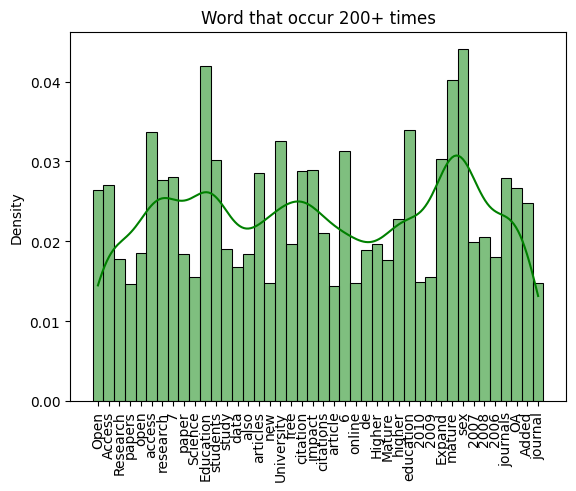

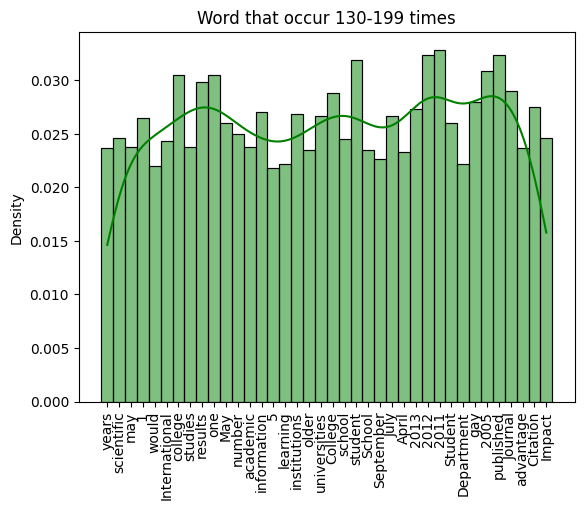

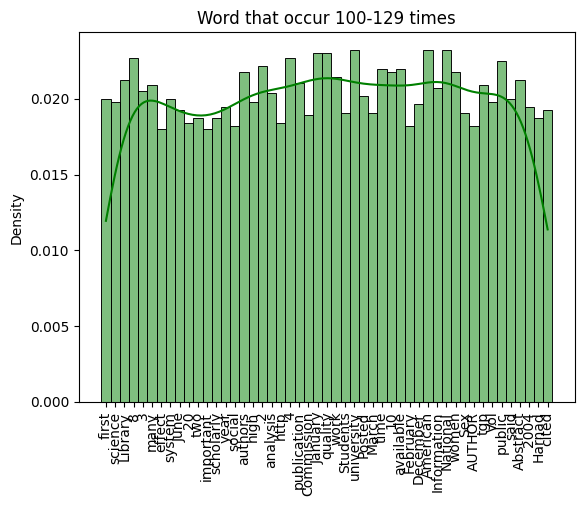

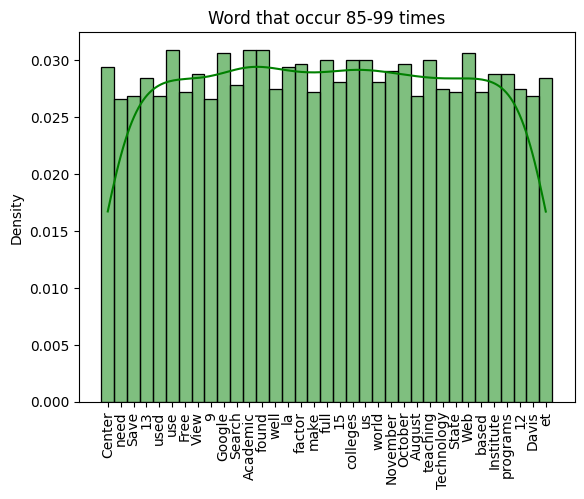

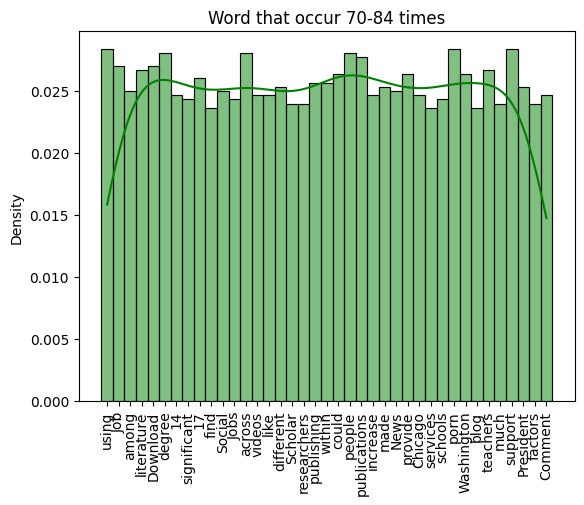

In [32]:
for idx, word_occ in enumerate(total_words_occurences):
    allWords = [key for key, val in word_occ.items() for i in range(val)]

    sns.histplot(allWords, kde=True, color="green", stat="density")
    plt.title(f"Word that occur {labels[idx]} times")
    plt.xticks(rotation = 90)
    plt.show()

### Line Graph

For the first dataframe, the data shows the amount of candidates and their performance on EEACAES over the years.

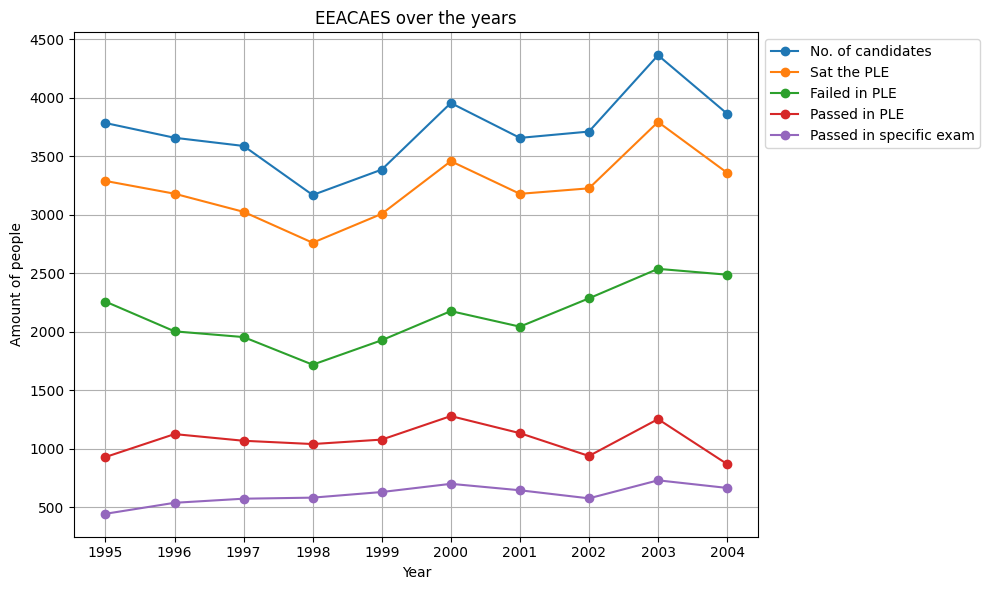

In [33]:
plt.figure(figsize=(10, 6))

plot_cols = df1.columns[1:]
plot_cols = plot_cols[~plot_cols.isin(["Fail rate in PLE (%)", "Pass rate in PLE (%)"])]

for column in plot_cols:
    plt.plot(df1["Year"], df1[column], marker="o", label=column)

plt.xlabel("Year")
plt.ylabel("Amount of people")
plt.title("EEACAES over the years")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)

plt.tight_layout()
plt.show()

### Box Plot

For the second dataframe, we're analysing the percentage of 23+ students enrolled in the first year for the first time in public institutions, in the years 2012-13 and 2013-14. Since it contains a lot of data, we can use a boxplot to visualize the distribution by checking the quartiles, minimum/maximum values, outliers, and the skewness of the data.

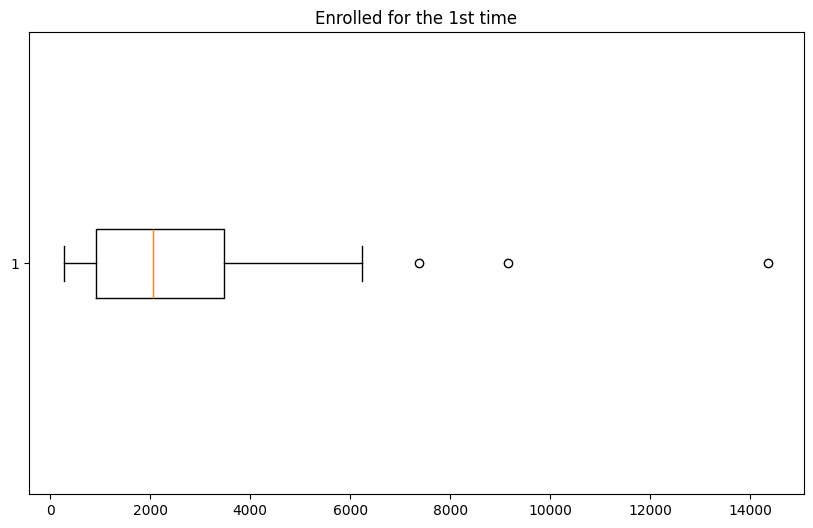

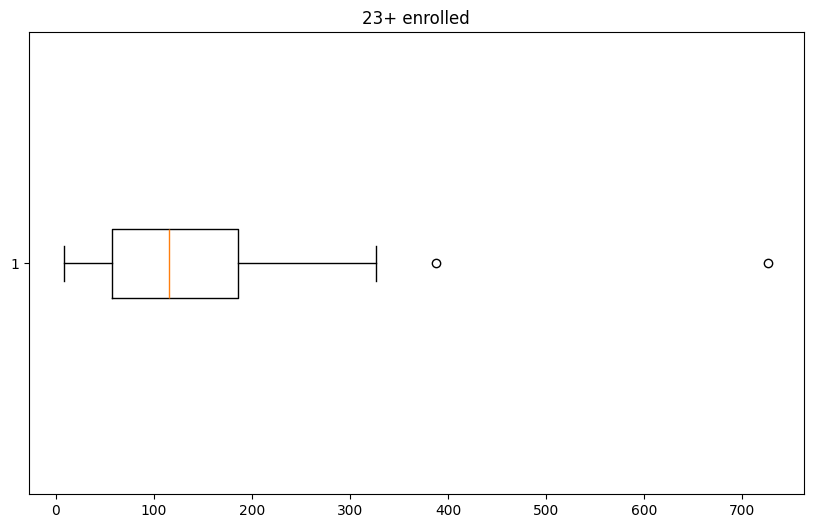

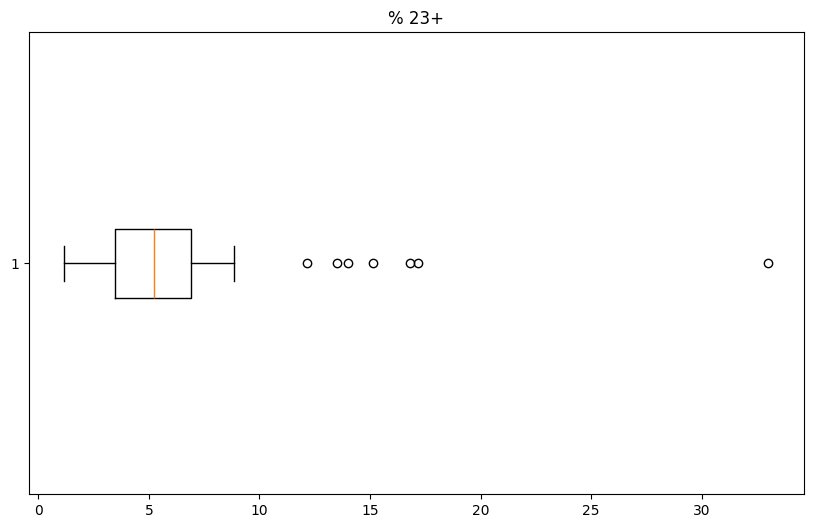

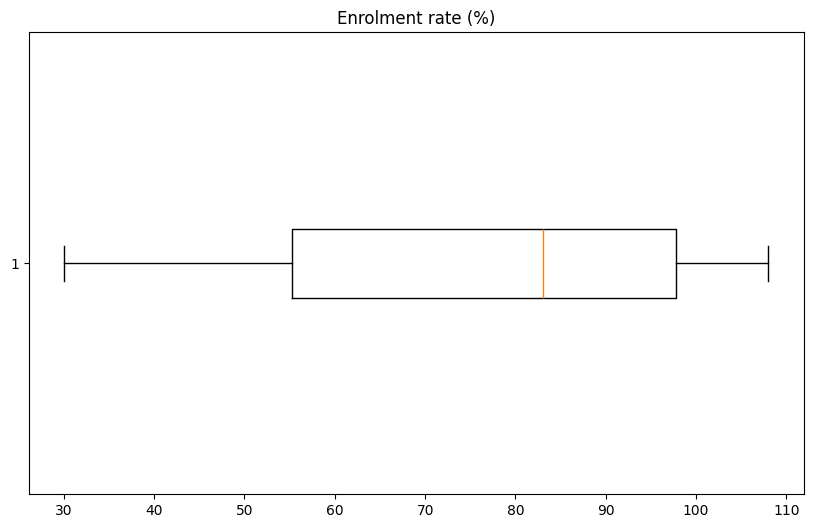

In [34]:
plt.figure(figsize=(10, 6))
plt.boxplot(df2["Enrolled for the 1st time"], vert=False)
plt.title("Enrolled for the 1st time")
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(df2["23+ enrolled"], vert=False)
plt.title("23+ enrolled")
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(df2["% 23+"], vert=False)
plt.title("% 23+")
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(df2["Enrolment rate (%)"], vert=False)
plt.title("Enrolment rate (%)")
plt.show()

### Scatter Plot

For the fifth dataframe, we're examining the distribution of available places for 23+ students compared to the actual number of 23+ students who were admitted, across various faculties, during that same time period of 2012-13 and 2013-14.

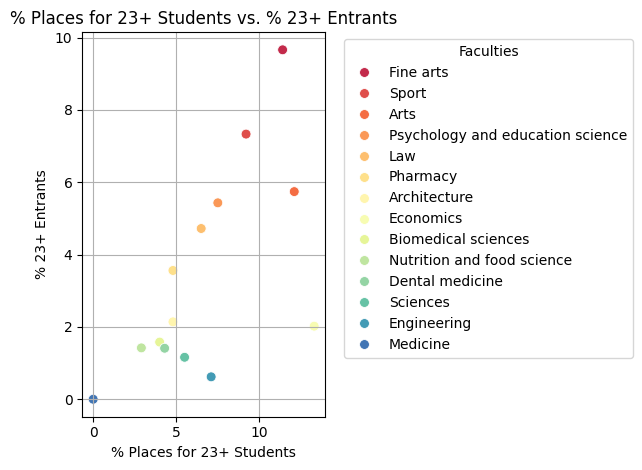

In [35]:
scatter_data = df5[df5["Faculties"] != "Total"]

sns.scatterplot(data=scatter_data, x="% places for 23+ students", y="% 23+ entrants", hue="Faculties", palette="Spectral", s=50)

plt.title("% Places for 23+ Students vs. % 23+ Entrants")
plt.xlabel("% Places for 23+ Students")
plt.ylabel("% 23+ Entrants")
plt.legend(title="Faculties", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

plt.tight_layout()
plt.show()

### Grouped Bar Graph

For the forth dataframe, we're analysing the percentage of HE students of different age groups and in different types of institutions, in 2013-14.

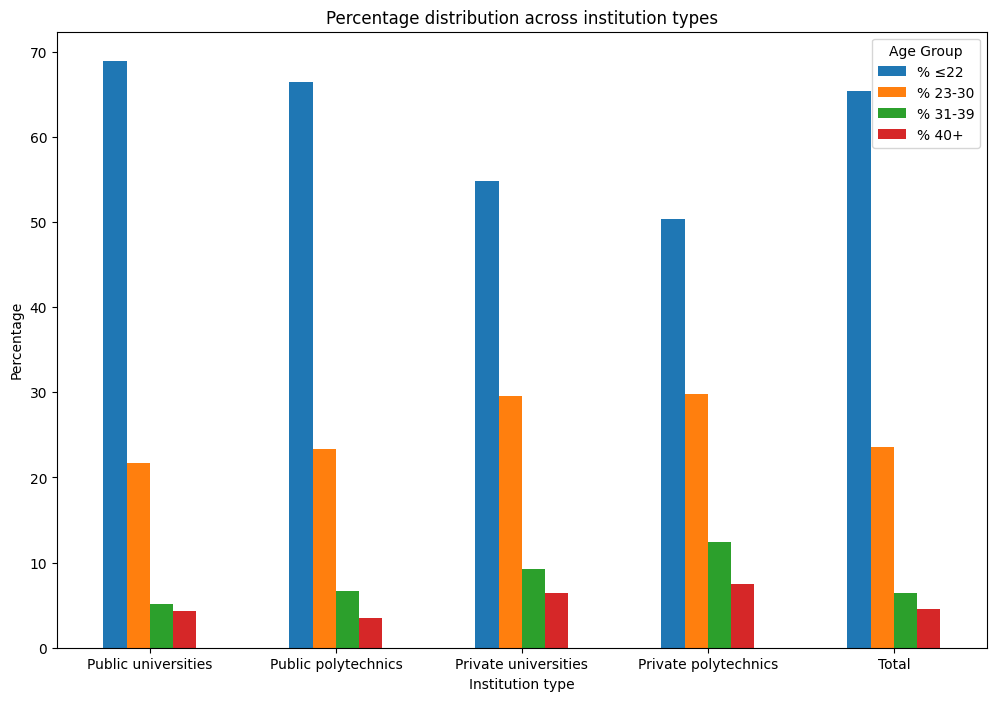

In [36]:
df4.set_index("Institution type")[["% ≤22", "% 23-30", "% 31-39", "% 40+"]].plot(kind="bar", figsize=(12,8))

plt.title("Percentage distribution across institution types")
plt.ylabel("Percentage")
plt.xticks(rotation = 0)
plt.legend(title="Age Group")

plt.show()

### Min-Max Scaling and PCA

For the third dataframe, we'll be interested only in the $\textbf{23+ enrolled}$ and $\textbf{18-22 enrolled}$ columns. From there, we'll apply Min-Max Scaling, so that the data ranges from 0 to 1. Then, we'll apply PCA to split the data into clusters, and usually to reduce dimensionality, but in this case that is not needed.

In [37]:
test_df3 = df3.drop(columns=["HE Institution", "Type", "1st time", "% 23+", "% 18-22"])

mean = test_df3.mean()
std = test_df3.std()

test_df3["z-score 23+"] = (test_df3["23+ enrolled"] - mean["23+ enrolled"]) / std["23+ enrolled"]
test_df3["z-score 18-22"] = (test_df3["18-22 enrolled"] - mean["18-22 enrolled"]) / std["18-22 enrolled"]

# Only z-scores below 0.55 accepted, for example. This is because original data is too clustered and so we want more spread.

zscore = (abs(test_df3["z-score 23+"]) > 0.55) | (abs(test_df3["z-score 18-22"]) > 0.55)

test_df3 = test_df3[~zscore].reset_index(drop=True)

test_df3 = test_df3.drop(columns=["z-score 23+", "z-score 18-22"])

scaler = preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(test_df3)
scaled_df = pd.DataFrame(scaled_data, columns=test_df3.columns)

scaled_df.head(20)

,23+ enrolled,18-22 enrolled
0,0.302632,0.004454
1,0.750000,0.042316
2,0.328947,0.015590
3,0.315789,0.020045
4,1.000000,0.080178
5,0.815789,0.071269
6,0.947368,0.097996
7,0.118421,0.008909
8,0.039474,0.000000
9,0.105263,0.008909


In [38]:
scaled_df.describe()    # Some rows were removed for having values considered to be outliers

,23+ enrolled,18-22 enrolled
count,61.000000,61.000000
mean,0.336066,0.192778
std,0.286655,0.218156
min,0.000000,0.000000
25%,0.105263,0.064588
50%,0.223684,0.133630
75%,0.539474,0.218263
max,1.000000,1.000000


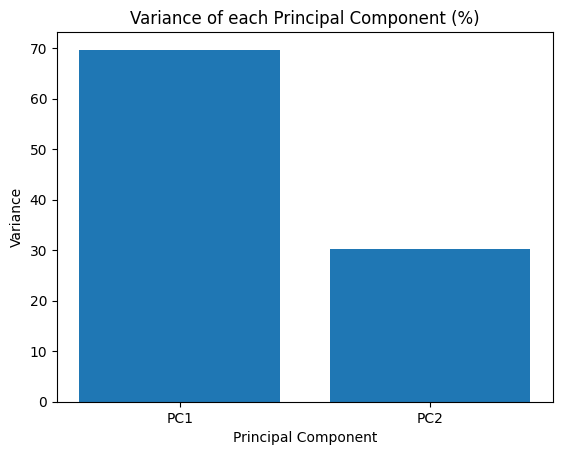

In [39]:
pca = PCA()
pca.fit(scaled_df)
pca_data = pca.transform(scaled_df)

perc_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ["PC" + str(x) for x in range(1, len(perc_var)+1)]

plt.bar(x=range(1,len(perc_var)+1), height=perc_var, tick_label=labels)
plt.xlabel("Principal Component")
plt.ylabel("Variance")
plt.title("Variance of each Principal Component (%)")
plt.show()

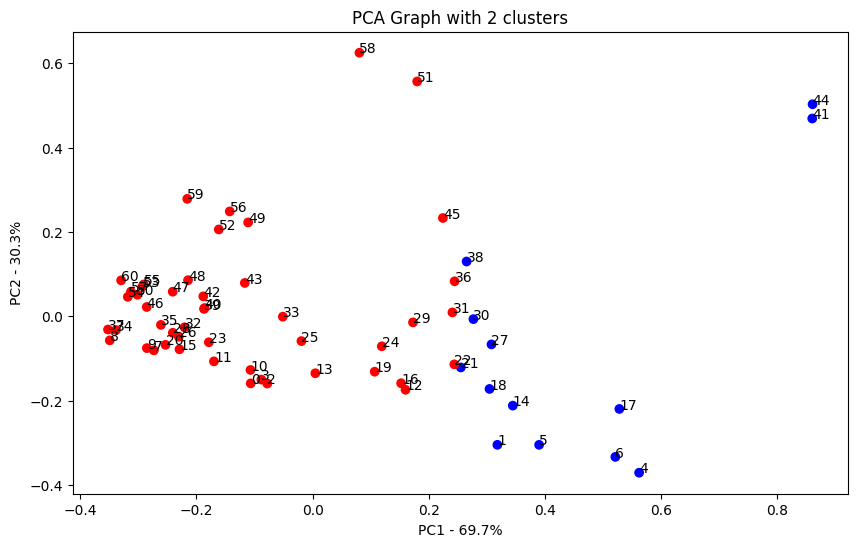

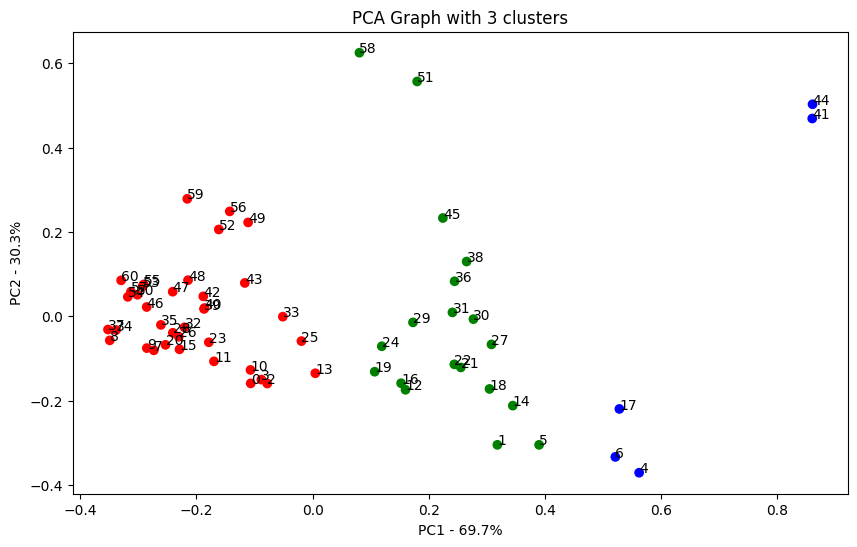

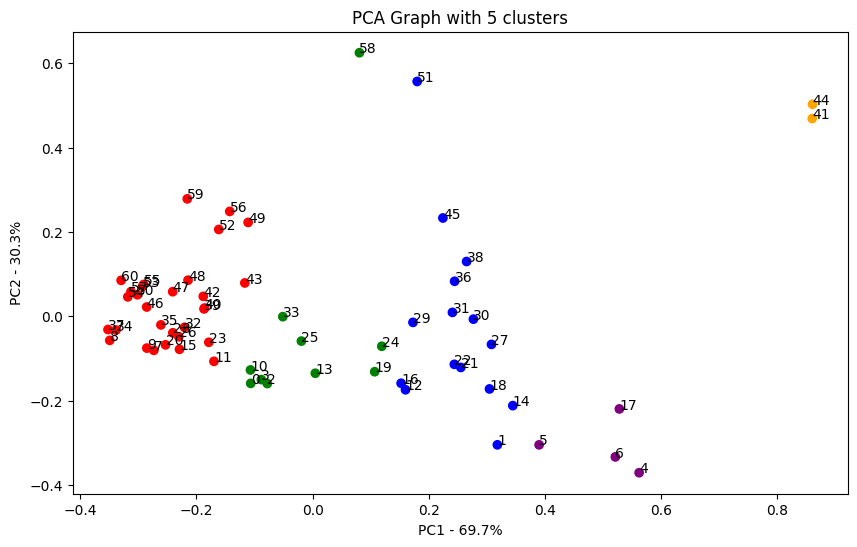

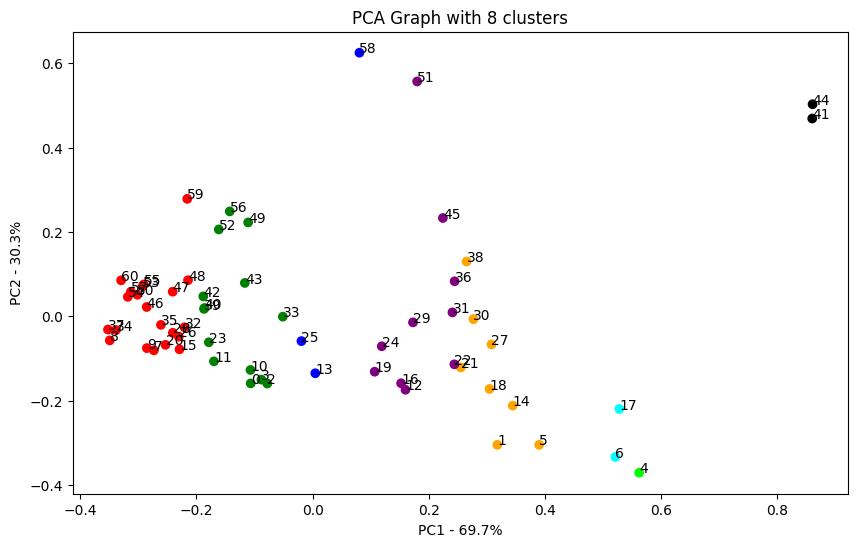

In [40]:
pca_df = pd.DataFrame(pca_data, index=scaled_df.index, columns=labels)

# Using different amounts of colors shows different clusters

color_types = [["red", "green", "blue", "purple", "orange", "cyan", "lime", "black"], ["red", "green", "blue", "purple", "orange"], ["red", "green", "blue"], ["red", "blue"]]


for cor in reversed(color_types):
    color = ListedColormap(cor)

    plt.figure(figsize=(10, 6))

    plt.scatter(pca_df.PC1, pca_df.PC2, c=pca_df.PC1, cmap=color)
    plt.xlabel(f"PC1 - {perc_var[0]}%")
    plt.ylabel(f"PC2 - {perc_var[1]}%")
    plt.title(f"PCA Graph with {len(cor)} clusters")

    for sample in pca_df.index:
        plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

    plt.show()